<a href="https://colab.research.google.com/github/FraSab98/Fake_news/blob/main/Fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import csv
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
from google.colab import files
files.upload()  # Questo ti permette di caricare il file kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"francescosabia","key":"0f56acfa87a8a58ce65a08921381cc20"}'}

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Imposta i permessi corretti


In [5]:
!kaggle datasets download -d saurabhshahane/fake-news-classification  # Sostituisci <dataset-path> con il path del dataset su Kaggle


Dataset URL: https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification
License(s): Attribution 4.0 International (CC BY 4.0)
fake-news-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip fake-news-classification.zip  # Sostituisci <dataset-file> con il nome del file scaricato

Archive:  fake-news-classification.zip
replace WELFake_Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: WELFake_Dataset.csv     


In [7]:
df = pd.read_csv("WELFake_Dataset.csv")
df.head()


,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [9]:
df['label'].value_counts()

label
1    37106
0    35028
Name: count, dtype: int64

In [10]:
df.shape

(72134, 4)

In [11]:
df.isna().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

In [12]:
df = df.dropna() #Handled Missing values by droping those rows

In [13]:
df.isna().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [14]:
df.shape

(71537, 4)

In [15]:
df.reset_index(inplace=True)
df.head()

,index,Unnamed: 0,title,text,label
0,0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
2,3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
3,4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
4,5,5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1


In [16]:
df['title'][0]

'LAW ENFORCEMENT ON HIGH ALERT Following Threats Against Cops And Whites On 9-11By #BlackLivesMatter And #FYF911 Terrorists [VIDEO]'

In [17]:
df = df.drop(['Unnamed: 0'],axis = 1)
df.head()

,index,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
2,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
3,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
4,5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1


In [18]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def tokenize_text(text):
    return word_tokenize(text)

# Applica la tokenizzazione
df['tokenized_title'] = df['title'].apply(tokenize_text)
df['tokenized_text'] = df['text'].apply(tokenize_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
df['tokenized_title'][0]

['LAW',
 'ENFORCEMENT',
 'ON',
 'HIGH',
 'ALERT',
 'Following',
 'Threats',
 'Against',
 'Cops',
 'And',
 'Whites',
 'On',
 '9-11By',
 '#',
 'BlackLivesMatter',
 'And',
 '#',
 'FYF911',
 'Terrorists',
 '[',
 'VIDEO',
 ']']

In [20]:
def text_lower(text):
    # Converti il testo in minuscolo
    text = [[word.lower() for word in text.split()] for text in text]
    return text

def remove_special_characters(tokens):
    cleaned_tokens = [re.sub(r'[^a-zA-Z]+',  # Search for all non-letters
                          "",          # Replace all non-letters with spaces
                          str(token)) for token in tokens]
    # Rimuove token vuoti che possono risultare dalla rimozione dei caratteri speciali
    return [token for token in cleaned_tokens if token]

# Scaricare le stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# Funzione per rimuovere le stop words da una lista di token
def remove_stopwords(tokens):
    return [token for token in tokens if token.lower() not in stop_words]

# Funzione combinata per pulire una lista di token
def clean_tokens(tokens):
    tokens = text_lower(tokens)
    tokens_no_special_chars = remove_special_characters(tokens)
    cleaned_tokens = remove_stopwords(tokens_no_special_chars)
    return cleaned_tokens

# Applica la pulizia del testo
df['clean_title'] = df['tokenized_title'].apply(clean_tokens)
df['clean_text'] = df['tokenized_text'].apply(clean_tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
df['clean_title'][0]

['law',
 'enforcement',
 'high',
 'alert',
 'following',
 'threats',
 'cops',
 'whites',
 'blacklivesmatter',
 'fyf',
 'terrorists',
 'video']

In [27]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def apply_lemmatization(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

df['title_lemma'] = df['clean_title'].apply(apply_lemmatization)
df['text_lemma'] = df['clean_text'].apply(apply_lemmatization)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [28]:
df['title_lemma'][0]

['law',
 'enforcement',
 'high',
 'alert',
 'following',
 'threat',
 'cop',
 'white',
 'blacklivesmatter',
 'fyf',
 'terrorist',
 'video']

In [22]:
# Inizializzare il PorterStemmer
stemmer = PorterStemmer()

# Funzione per applicare lo stemming a una lista di token
def apply_stemming(tokens):
    return [stemmer.stem(token) for token in tokens]

df['title_stem'] = df['clean_title'].apply(apply_stemming)
df['text_stem'] = df['clean_text'].apply(apply_stemming)

In [34]:
df['text_stem'][0]

['law',
 'enforc',
 'high',
 'alert',
 'follow',
 'threat',
 'cop',
 'white',
 'blacklivesmatt',
 'fyf',
 'terrorist',
 'video']

In [29]:
# df['combine'] = df['title_stem'] + df['text_stem']
# df['combine'] = df['text_stem']
df['combine'] = df['text_lemma']
df['combine'] = [' '.join(tokens) for tokens in df['combine']]
len(df['combine'])



71537

In [30]:
#splitting data for training and testing
import sklearn
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(df['combine'],df['label'],test_size=0.3, random_state = 1, stratify = y)

len(x_train),len(y_train),len(x_test),len(y_test)


(50075, 50075, 21462, 21462)

In [ ]:
class Preprocessing:

    def __init__(self,data):
        self.data = data

    def text_preprocessing_user(self):
        lm = WordNetLemmatizer()
        pred_data = [self.data]
        preprocess_data = []
        for data in pred_data:
            review = re.sub('^a-zA-Z0-9',' ', data)
            review = review.lower()
            review = review.split()
            review = [lm.lemmatize(x) for x in review if x not in stopwords]
            review = " ".join(review)
            preprocess_data.append(review)
        return preprocess_data

accuracy:   96.133


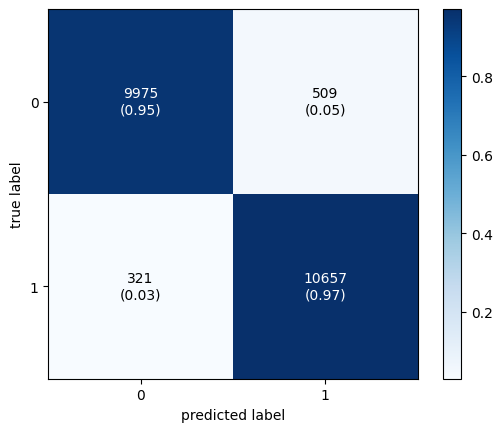

In [36]:
#SVM
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC())
])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)

score = metrics.accuracy_score(y_test, prediction)
print("accuracy:   %0.3f" % (score*100))
cm = metrics.confusion_matrix(y_test, prediction, labels=[0,1])



fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()



In [41]:
class Evaluation:

    def __init__(self,model,x_train,x_test,y_train,y_test):
        self.model = model
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

    def train_evaluation(self):
        y_pred_train = self.model.predict(self.x_train)

        acc_scr_train = accuracy_score(self.y_train,y_pred_train)
        print("Accuracy Score On Training Data Set :",acc_scr_train)
        print()

        con_mat_train = confusion_matrix(self.y_train,y_pred_train)
        print("Confusion Matrix On Training Data Set :\n",con_mat_train)
        print()

        class_rep_train = classification_report(self.y_train,y_pred_train)
        print("Classification Report On Training Data Set :\n",class_rep_train)


    def test_evaluation(self):
        y_pred_test = self.model.predict(self.x_test)

        acc_scr_test = accuracy_score(self.y_test,y_pred_test)
        print("Accuracy Score On Testing Data Set :",acc_scr_test)
        print()

        con_mat_test = confusion_matrix(self.y_test,y_pred_test)
        print("Confusion Matrix On Testing Data Set :\n",con_mat_test)
        print()

        class_rep_test = classification_report(self.y_test,y_pred_test)
        print("Classification Report On Testing Data Set :\n",class_rep_test)

# Evaluation(model,x_train, x_test, y_train, y_test).train_evaluation()

In [42]:
Evaluation(model,x_train, x_test, y_train, y_test).test_evaluation()

Accuracy Score On Testing Data Set : 0.9613269965520455

Confusion Matrix On Testing Data Set :
 [[ 9975   509]
 [  321 10657]]

Classification Report On Testing Data Set :
               precision    recall  f1-score   support

           0       0.97      0.95      0.96     10484
           1       0.95      0.97      0.96     10978

    accuracy                           0.96     21462
   macro avg       0.96      0.96      0.96     21462
weighted avg       0.96      0.96      0.96     21462



TESTING su dati non etichettati

In [79]:
fake_news = "Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t even allow him to rise above the gutter long enough to wish the American citizens a happy new year!  Bishop Talbert Swan (@TalbertSwan) December 31, 2017no one likes you  Calvin (@calvinstowell) December 31, 2017Your impeachment would make 2018 a great year for America, but I ll also accept regaining control of Congress.  Miranda Yaver (@mirandayaver) December 31, 2017Do you hear yourself talk? When you have to include that many people that hate you you have to wonder? Why do the they all hate me?  Alan Sandoval (@AlanSandoval13) December 31, 2017Who uses the word Haters in a New Years wish??  Marlene (@marlene399) December 31, 2017You can t just say happy new year?  Koren pollitt (@Korencarpenter) December 31, 2017Here s Trump s New Year s Eve tweet from 2016.Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love!  Donald J. Trump (@realDonaldTrump) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his  enemies  and  haters  for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA  Daniel Dale (@ddale8) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President?  Steven Goodine (@SGoodine) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down.  Roy Schulze (@thbthttt) December 31, 2017Who, apart from a teenager uses the term haters?  Wendy (@WendyWhistles) December 31, 2017he s a fucking 5 year old  Who Knows (@rainyday80) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images."

tokens = tokenize_text(fake_news)

clean_text = clean_tokens(tokens)

lemma_text = apply_lemmatization(clean_text)

df = pd.DataFrame(lemma_text)

fake_news_end = ' '.join(df[0])
fake_news_end = [fake_news_end]

cv = CountVectorizer()
count_vectorized = cv.fit_transform(fake_news_end)

tf = TfidfVectorizer()
tfidf_vectorized = tf.fit_transform(fake_news_end).toarray()

model.predict(fake_news_end)


array([1])

accuracy:   93.006


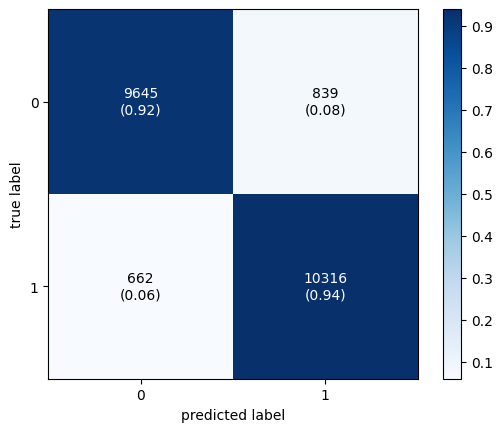

In [32]:
# Importa il RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

# Crea la pipeline con RandomForestClassifier
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42)) # ottimizzare gli iperparametri
])

# Addestra il modello
model = pipe.fit(x_train, y_train)

# Fai le predizioni
prediction = model.predict(x_test)

# Calcola l'accuratezza
score = accuracy_score(y_test, prediction)
print("accuracy:   %0.3f" % (score * 100))

# Calcola la matrice di confusione
cm = confusion_matrix(y_test, prediction, labels=[0, 1])

# Visualizza la matrice di confusione
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()


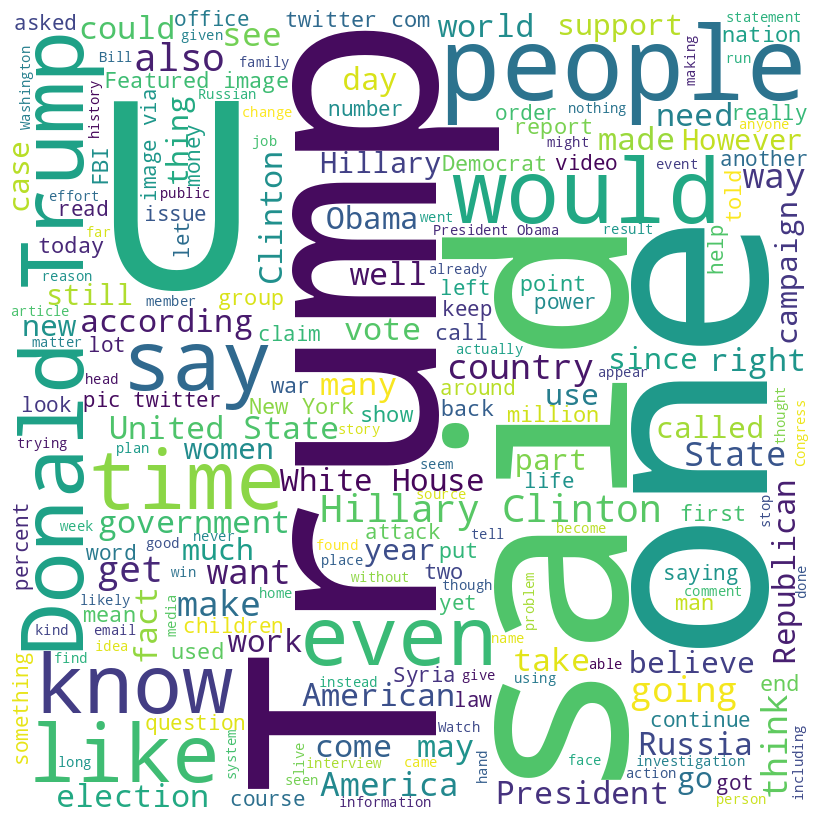

In [35]:
from nltk.corpus import stopwords
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords.words('english'),
                min_font_size = 10).generate(" ".join(df[df['label'] == 1].text))

# plot the word cloud for genuine news data
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

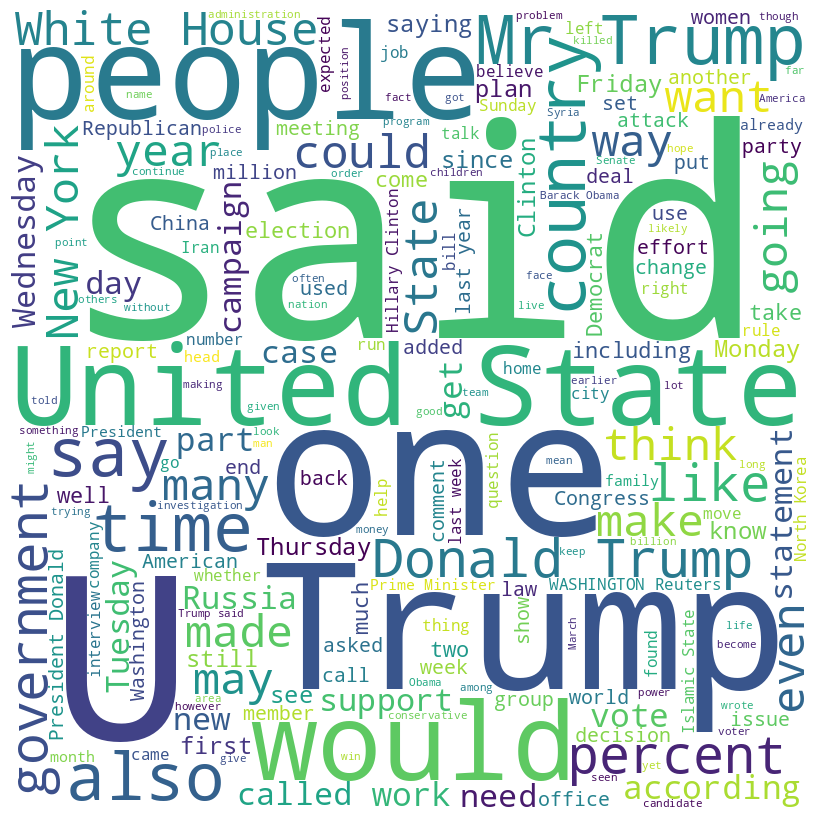

In [34]:
from nltk.corpus import stopwords
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords.words('english'),
                min_font_size = 10).generate(" ".join(df[df['label'] == 0].text))

# plot the word cloud for fake news data
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()